In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import pandas as pd
import operator
%matplotlib inline

In [4]:
class Environment:
    def __init__(self,urn, groups, mius, noise, tao, rewards, residuals):
        self.urn=urn
        self.groups=groups
        self.mius=mius
        self.noise=noise
        self.tao=tao
        self.rewards=rewards
        self.residuals=residuals
    def total_groups(self):
        return(len(self.groups))
    
    def total_neighborhoods(self):
        return(len(self.urn))
    
    def tot_urn(self):
        return(sum(self.urn))
    
    def rate_neighborhood(self, i):
        return(self.urn[i]/self.tot_urn())
    
    def reward_neighborhood(self, i):
        return(self.rewards[i])
    
    def mius_n(self):
        mius=[]
        for i in range(self.total_neighborhoods()):
            mius.append(self.mius[self.groups[i]])
        return mius
    
    def noise_n(self):
        sigmas=[]
        for i in range(self.total_neighborhoods()):
            sigmas.append(self.noise[self.groups[i]])
        return sigmas

In [209]:
def simulate_period(environment):
    
    
    #Crear el crimen y ruido de cada barrio.
    
    crime_n=[np.random.normal(loc=environment.mius_n()[i], scale=environment.noise_n()[i]) for i in range(environment.total_neighborhoods())]
    
    for i in crime_n:
        if i<0:       
            i=0
    
    
    # Se escoje a donde mandar Patrulleros dados los recursos
    likelihoods=[environment.rate_neighborhood(i) for i in range(environment.total_neighborhoods())]
    neighborhoods=np.random.choice(a=range(environment.total_neighborhoods()), p=likelihoods, 
                                   size=environment.tao, replace=False)

    # Se envían y añaden los crimenes del barrio donde vio. Además, se actualizan rewards.
    for i in neighborhoods:
        environment.urn[i]+=crime_n[i]
        environment.rewards[i]+=crime_n[i]        
   
    # Se actualizan residuales
    for i in range(environment.total_neighborhoods()):
        if i not in neighborhoods:
            environment.residuals[i]+=crime_n[i]

    return(environment)  

In [231]:
def simulate_n_periods(environment, n, verbose=False):
    
    history_rewards=[environment.rewards.copy()]
    history_residuals=[environment.residuals.copy()]
    history_urn=[environment.urn.copy()]
    rates=[environment.rate_neighborhood(i) for i in range(environment.total_neighborhoods())]
    history_rate_urn=[rates]
    
    for i in range(n):
        if verbose and i%100==0:
            print(i)
        
        simulate_period(environment)
        history_rewards.append(environment.rewards.copy())
        history_residuals.append(environment.residuals.copy())
        history_urn.append(environment.urn.copy())
        rates=[environment.rate_neighborhood(i) for i in range(environment.total_neighborhoods())]
        history_rate_urn.append(rates)
        
    return environment, history_rate_urn, history_urn, history_rewards, history_residuals

In [265]:
number_neighborhoods=5
world=Environment(urn=[10,79,20,50,15], groups=[1,0,1,1,0], mius=[2,3], noise=[2,2],tao=2, 
                  rewards=[0]*number_neighborhoods, residuals=[0]*number_neighborhoods)

In [266]:
world,history_rate_urn, history_urn, history_rewards, history_residuals=simulate_n_periods(world, 200, verbose=False)

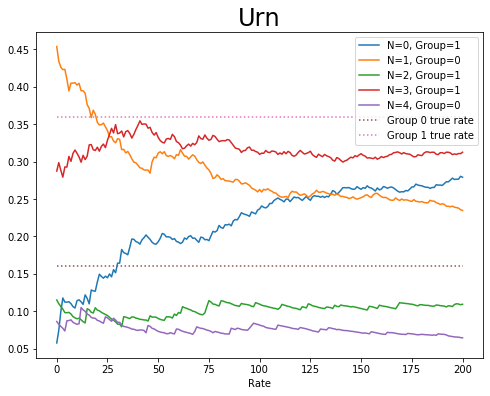

In [267]:
x_size=(len(history_rate_urn))
group_sizes=[world.groups.count(i)/len(world.groups) for i in list(set(world.groups))]


plt.figure(figsize=(8,6))
plt.title('Urn', fontsize=24)
for i in range(number_neighborhoods):
    plt.plot([j[i] for j in history_rate_urn], label='N='+str(i)+', Group='+str(world.groups[i]))
for i in range(len(world.mius)):
    plt.plot([(world.mius[i]*group_sizes[i]/sum(world.mius))]*x_size, 
             label='Group '+str(i)+' true rate', ls=':')
plt.xlabel('Period')
plt.xlabel('Rate')
plt.legend()

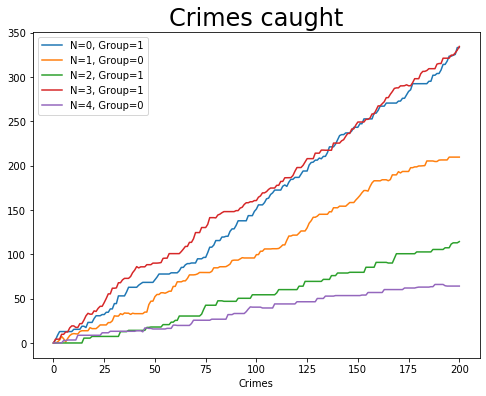

In [268]:
plt.figure(figsize=(8,6))
plt.title('Crimes caught', fontsize=24)
for i in range(number_neighborhoods):
    plt.plot([j[i] for j in history_rewards], label='N='+str(i)+', Group='+str(world.groups[i]))
plt.xlabel('Period')
plt.xlabel('Crimes')
plt.legend()

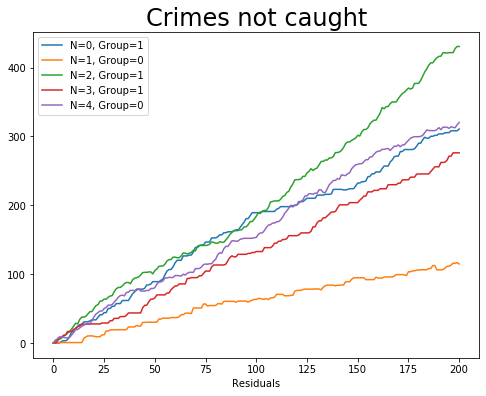

In [269]:
plt.figure(figsize=(8,6))
plt.title('Crimes not caught', fontsize=24)
for i in range(number_neighborhoods):
    plt.plot([j[i] for j in history_residuals], label='N='+str(i)+', Group='+str(world.groups[i]))
plt.xlabel('Period')
plt.xlabel('Residuals')
plt.legend()

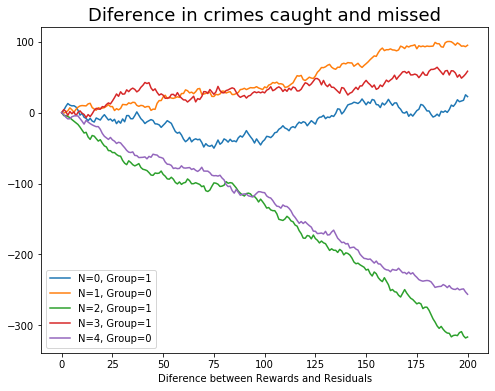

In [270]:
plt.figure(figsize=(8,6))
plt.title('Diference in crimes caught and missed', fontsize=18)
for i in range(number_neighborhoods):
    plt.plot([history_rewards[j][i]-history_residuals[j][i] for j in range(len(history_rewards))], 
             label='N='+str(i)+', Group='+str(world.groups[i]))
plt.xlabel('Period')
plt.xlabel('Diference between Rewards and Residuals')
plt.legend()